In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
## Read Data
dataset_train = pd.read_csv('GOOG.csv')
cols = list(dataset_train)[1:6]
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestampes == {}'.format(len(datelist_train)))
print('Feature selected: {}'.format(cols))

Training set shape == (4006, 7)
All timestampes == 4006
Feature selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [3]:
## Data pre-processing
#dataset_train.head()
dataset_train = dataset_train[cols].astype(str)
for i in cols:
  for j in range(0, len(dataset_train)):
    dataset_train[i][j] = dataset_train[i][j].replace(',','')
dataset_train = dataset_train.astype(float)

training_set = dataset_train.to_numpy()

print('Shape of training set =={}'.format(training_set.shape))
training_set

Shape of training set ==(4006, 5)


array([[  49.813286,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [4]:
## feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])

array([[-1.27195197],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [5]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60
n_past = 90
# we want to use past 90 days to predict future 60 day's prices

for i in range(n_past, len(training_set_scaled)-n_future+1):
  X_train.append(training_set_scaled[i-n_past:i, 0:dataset_train.shape[1]-1])
  y_train.append(training_set_scaled[i+n_future-1:i+n_future,0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3857, 90, 4).
y_train shape == (3857, 1).


In [6]:
## LSTM based NN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [7]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past,dataset_train.shape[1]-1)))
model.add(LSTM(units=10, return_sequences= False))
model.add(Dropout(0.25))
model.add(Dense(units=1,activation ='linear'))
model.compile(optimizer=Adam(learning_rate = 0.01), loss='mean_squared_error')

In [8]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta = 1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor ='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle =True, epochs=30, callbacks=[es,rlr,mcp,tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.1522
Epoch 1: val_loss improved from inf to 0.33766, saving model to weights.h5
13/13 [==============================] - 8s 323ms/step - loss: 0.1522 - val_loss: 0.3377 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0419
Epoch 2: val_loss did not improve from 0.33766
13/13 [==============================] - 5s 373ms/step - loss: 0.0419 - val_loss: 0.4520 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0370
Epoch 3: val_loss improved from 0.33766 to 0.16196, saving model to weights.h5
13/13 [==============================] - 3s 257ms/step - loss: 0.0370 - val_loss: 0.1620 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0363
Epoch 4: val_loss improved from 0.16196 to 0.13607, saving model to weights.h5
13/13 [==============================] - 3s 231ms/step - loss: 0.0363 - val_loss: 0.1361 - lr: 0.0100
Epoch 5/30
1

In [9]:
## Make predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
datelist_future_ = []
for this_timestamp in datelist_future:
  datelist_future_.append(this_timestamp.date())
print(datelist_future_[:5])
print(datelist_train[-1])

[datetime.date(2020, 7, 17), datetime.date(2020, 7, 18), datetime.date(2020, 7, 19), datetime.date(2020, 7, 20), datetime.date(2020, 7, 21)]
2020-07-17


In [10]:
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

118/118 [==============================] - 3s 21ms/step


In [11]:
def datetime_to_timestamp(x):
  return datetime.strptime(x.strftime('%Y%m%d'),'%Y%m%d')

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2005-08-01,153.127731
2005-08-02,153.512405
2005-08-03,153.786087


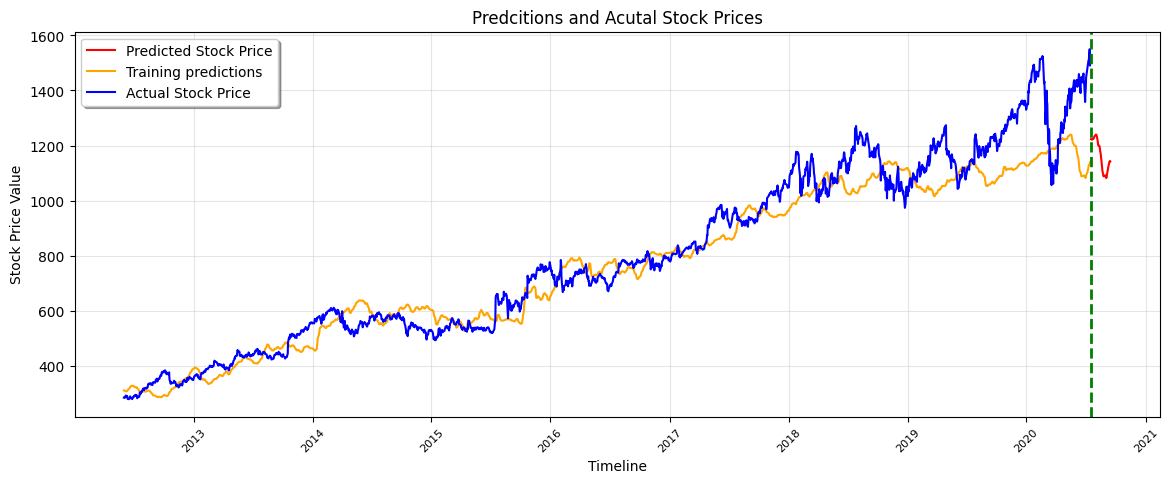

In [15]:
## visualize the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Stock Price Value', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()


In [14]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)